In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch.nn.functional as F  # Needed for Focal Loss
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.datasets import ImageFolder 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
# No longer need class_weight import
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# --- Global Configuration ---
NUM_CLASSES = 3 
CLASS_NAMES = ['Normal', 'Benign', 'Malignant']
IMAGE_SIZE = 224
BATCH_SIZE = 64
HEAD_EPOCHS = 10  # Epochs for head training
FINE_TUNE_EPOCHS = 50 # Epochs for full fine-tuning
NUM_WORKERS = 0 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = '/kaggle/input/cancerclassification/Classification/Image' 

print(f"✅ Using device: {DEVICE}")

# --- Focal Loss Implementation (Moved to Block 1) ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        if alpha is not None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)

    def forward(self, inputs, targets):
        # inputs are raw logits (B, C), targets are labels (B)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt)**self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
            
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# --- Define Loss Function (Focal Loss) ---
CRITERION = FocalLoss(alpha=None, gamma=2).to(DEVICE)
print("\n⭐ Using **Focal Loss** for training (gamma=2).")

✅ Using device: cuda

⭐ Using **Focal Loss** for training (gamma=2).


In [9]:
# --- Squeeze-and-Excitation (SE) Layer Implementation ---
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) 
        y = self.fc(y).view(b, c, 1, 1) 
        return x * y.expand_as(x) 

# --- MODEL BUILDING FUNCTION (Fixed) ---
def build_convnext_with_se_head(num_classes):
    # 1. Load the pre-trained backbone
    base_model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    
    # 2. Extract the feature backbone
    backbone = base_model.features
    
    # 3. Get the number of output channels from the backbone
    num_features = base_model.classifier[2].in_features # This is 768

    # 4. Create the new head
    new_head = nn.Sequential(
        SELayer(channel=num_features, reduction=16),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(num_features, num_classes)
    )
    
    # 5. Combine the backbone and the new head
    model = nn.Sequential(
        backbone,
        new_head
    )
    
    return model

model = build_convnext_with_se_head(NUM_CLASSES).to(DEVICE)

# --- Parameter Count ---
def count_all_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    untrainable_params = total_params - trainable_params
    return total_params, trainable_params, untrainable_params

total, trainable, untrainable = count_all_parameters(model)
print(f"\n✅ ConvNeXt + SE Head Model initialized (Simplified Architecture, Fixed).")
print(f"⭐ Total Parameters:        {total:,}")
print(f"⭐ Trainable Parameters:    {trainable:,}")
print(f"⭐ Untrainable Parameters:  {untrainable:,}")


✅ ConvNeXt + SE Head Model initialized (Simplified Architecture, Fixed).
⭐ Total Parameters:        27,894,627
⭐ Trainable Parameters:    27,894,627
⭐ Untrainable Parameters:  0


In [10]:
# --- Augmentation Pipelines ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.2), 
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.6),
    A.RandomBrightnessContrast(p=0.5), A.GaussNoise(p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2(),
])
val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2(),
])
# --- FIX: Define test_transform ---
test_transform = val_transform 

# Helper class (Unchanged)
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        path, label = self.subset.dataset.samples[self.subset.indices[index]]
        img = np.array(Image.open(path).convert("RGB"))
        if self.transform is not None:
            augmented = self.transform(image=img)
            img = augmented['image']
        return img, label
    def __len__(self):
        return len(self.subset)

# --- Data Loading and Splitting (80/10/10) ---
full_dataset = ImageFolder(DATA_PATH)
TRAIN_RATIO, VAL_RATIO = 0.80, 0.10
total_size = len(full_dataset)
train_size = int(TRAIN_RATIO * total_size)
val_size = int(VAL_RATIO * total_size)
test_size = total_size - train_size - val_size 
print(f"Data Split (80/10/10): Total: {total_size} | Train: {train_size} | Val: {val_size} | Test: {test_size}")

train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)
train_dataset = SubsetWithTransform(train_subset, transform=train_transform)
val_dataset = SubsetWithTransform(val_subset, transform=val_transform)
test_dataset = SubsetWithTransform(test_subset, transform=test_transform) # This line is now correct
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(f"\n✅ DataLoaders initialized.")

Data Split (80/10/10): Total: 1665 | Train: 1332 | Val: 166 | Test: 167

✅ DataLoaders initialized.


In [11]:
# --- Training and Evaluation Functions ---
def train_one_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += loss.item() * images.size(0)
    
    if scheduler is not None:
        scheduler.step()
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device, desc="Validation"):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=desc):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds), np.array(all_probs)

# --- STAGE 1: HEAD TRAINING (Simplified Freezing) ---
print("\n--- Starting Stage 1: Head Training (Backbone Frozen) ---")

# Freeze the entire backbone (model[0])
for param in model[0].parameters():
    param.requires_grad = False
    
HEAD_LR = 1e-3
# The optimizer only gets parameters from the new head (model[1])
head_optimizer = optim.AdamW(model[1].parameters(), lr=HEAD_LR, weight_decay=1e-2) 

print("Verifying trainable parameters for Stage 1...")
total, trainable, untrainable = count_all_parameters(model)
print(f"⭐ Trainable (Head+SE):   {trainable:,}")
print(f"⭐ Untrainable (Backbone): {untrainable:,}")

for epoch in range(HEAD_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, CRITERION, head_optimizer, DEVICE, scheduler=None)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, CRITERION, DEVICE, desc="Head Validation")
    print(f"Head Epoch {epoch+1}/{HEAD_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


# --- STAGE 2: FULL FINE-TUNING ---
print("\n--- Starting Stage 2: Full Fine-Tuning (Unfreezing All Layers) ---")
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

FINE_TUNE_LR = 1e-4 
WEIGHT_DECAY = 1e-2 
OPTIMIZER = optim.AdamW(model.parameters(), lr=FINE_TUNE_LR, weight_decay=WEIGHT_DECAY) 
SCHEDULER = lr_scheduler.CosineAnnealingLR(OPTIMIZER, T_max=FINE_TUNE_EPOCHS) 

train_losses, val_losses, val_accuracies = [], [], []
final_labels, final_preds, final_probs = None, None, None 

for epoch in range(FINE_TUNE_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, CRITERION, OPTIMIZER, DEVICE, SCHEDULER)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, CRITERION, DEVICE, desc="Fine-Tune Validation")
    print(f"Fine-Tune Epoch {epoch+1}/{FINE_TUNE_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    train_losses.append(train_loss); val_losses.append(val_loss); val_accuracies.append(val_acc)

print("✅ Training complete.")

# --- Final Evaluation on Test Set ---
print(f"\n--- Running Final Evaluation on Test Set ---")
test_loss, test_acc, final_labels, final_preds, final_probs = evaluate(
    model, test_loader, CRITERION, DEVICE, desc="Testing"
)
print(f"✅ Test Evaluation Complete | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


--- Starting Stage 1: Head Training (Backbone Frozen) ---
Verifying trainable parameters for Stage 1...
⭐ Trainable (Head+SE):   76,035
⭐ Untrainable (Backbone): 27,818,592


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 1/10 | Train Loss: 0.4695 | Val Loss: 0.4461 | Val Acc: 0.5482


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 2/10 | Train Loss: 0.4399 | Val Loss: 0.3954 | Val Acc: 0.5723


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 3/10 | Train Loss: 0.4085 | Val Loss: 0.3536 | Val Acc: 0.6205


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 4/10 | Train Loss: 0.3803 | Val Loss: 0.3296 | Val Acc: 0.6747


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 5/10 | Train Loss: 0.3653 | Val Loss: 0.3054 | Val Acc: 0.7229


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 6/10 | Train Loss: 0.3508 | Val Loss: 0.2900 | Val Acc: 0.7169


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 7/10 | Train Loss: 0.3356 | Val Loss: 0.2910 | Val Acc: 0.7108


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 8/10 | Train Loss: 0.3240 | Val Loss: 0.2702 | Val Acc: 0.7470


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 9/10 | Train Loss: 0.3155 | Val Loss: 0.2604 | Val Acc: 0.7590


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Head Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Head Epoch 10/10 | Train Loss: 0.3126 | Val Loss: 0.2515 | Val Acc: 0.7470

--- Starting Stage 2: Full Fine-Tuning (Unfreezing All Layers) ---


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 1/50 | Train Loss: 0.2997 | Val Loss: 0.1531 | Val Acc: 0.8434


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 2/50 | Train Loss: 0.2119 | Val Loss: 0.1221 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 3/50 | Train Loss: 0.1753 | Val Loss: 0.1205 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 4/50 | Train Loss: 0.1769 | Val Loss: 0.1068 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 5/50 | Train Loss: 0.1465 | Val Loss: 0.1151 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 6/50 | Train Loss: 0.1253 | Val Loss: 0.1032 | Val Acc: 0.8855


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 7/50 | Train Loss: 0.1162 | Val Loss: 0.1323 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 8/50 | Train Loss: 0.1252 | Val Loss: 0.1163 | Val Acc: 0.8855


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 9/50 | Train Loss: 0.1183 | Val Loss: 0.1129 | Val Acc: 0.9036


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 10/50 | Train Loss: 0.1107 | Val Loss: 0.1160 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 11/50 | Train Loss: 0.0920 | Val Loss: 0.1275 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 12/50 | Train Loss: 0.0897 | Val Loss: 0.1429 | Val Acc: 0.8675


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 13/50 | Train Loss: 0.0809 | Val Loss: 0.1436 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 14/50 | Train Loss: 0.0797 | Val Loss: 0.1417 | Val Acc: 0.8976


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 15/50 | Train Loss: 0.0699 | Val Loss: 0.1366 | Val Acc: 0.8976


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 16/50 | Train Loss: 0.0749 | Val Loss: 0.1551 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 17/50 | Train Loss: 0.0776 | Val Loss: 0.1545 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 18/50 | Train Loss: 0.0627 | Val Loss: 0.1666 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 19/50 | Train Loss: 0.0596 | Val Loss: 0.1598 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 20/50 | Train Loss: 0.0505 | Val Loss: 0.1717 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 21/50 | Train Loss: 0.0441 | Val Loss: 0.1567 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 22/50 | Train Loss: 0.0531 | Val Loss: 0.1739 | Val Acc: 0.8855


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 23/50 | Train Loss: 0.0509 | Val Loss: 0.1389 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 24/50 | Train Loss: 0.0489 | Val Loss: 0.1696 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 25/50 | Train Loss: 0.0407 | Val Loss: 0.1772 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 26/50 | Train Loss: 0.0439 | Val Loss: 0.1510 | Val Acc: 0.9036


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 27/50 | Train Loss: 0.0389 | Val Loss: 0.1456 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 28/50 | Train Loss: 0.0382 | Val Loss: 0.1843 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 29/50 | Train Loss: 0.0351 | Val Loss: 0.1601 | Val Acc: 0.8976


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 30/50 | Train Loss: 0.0293 | Val Loss: 0.1566 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 31/50 | Train Loss: 0.0393 | Val Loss: 0.1491 | Val Acc: 0.8976


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 32/50 | Train Loss: 0.0336 | Val Loss: 0.1480 | Val Acc: 0.8976


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 33/50 | Train Loss: 0.0358 | Val Loss: 0.1692 | Val Acc: 0.8916


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 34/50 | Train Loss: 0.0289 | Val Loss: 0.1944 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 35/50 | Train Loss: 0.0295 | Val Loss: 0.1676 | Val Acc: 0.8976


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 36/50 | Train Loss: 0.0370 | Val Loss: 0.1795 | Val Acc: 0.8855


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 37/50 | Train Loss: 0.0292 | Val Loss: 0.1960 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 38/50 | Train Loss: 0.0276 | Val Loss: 0.1927 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 39/50 | Train Loss: 0.0271 | Val Loss: 0.1939 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 40/50 | Train Loss: 0.0216 | Val Loss: 0.1918 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 41/50 | Train Loss: 0.0250 | Val Loss: 0.1949 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 42/50 | Train Loss: 0.0246 | Val Loss: 0.1988 | Val Acc: 0.8735


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 43/50 | Train Loss: 0.0247 | Val Loss: 0.1977 | Val Acc: 0.8855


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 44/50 | Train Loss: 0.0249 | Val Loss: 0.1973 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 45/50 | Train Loss: 0.0224 | Val Loss: 0.2013 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 46/50 | Train Loss: 0.0247 | Val Loss: 0.2088 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 47/50 | Train Loss: 0.0276 | Val Loss: 0.2086 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 48/50 | Train Loss: 0.0256 | Val Loss: 0.2073 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 49/50 | Train Loss: 0.0272 | Val Loss: 0.2068 | Val Acc: 0.8795


Training:   0%|          | 0/21 [00:00<?, ?it/s]

Fine-Tune Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Fine-Tune Epoch 50/50 | Train Loss: 0.0289 | Val Loss: 0.2065 | Val Acc: 0.8795
✅ Training complete.

--- Running Final Evaluation on Test Set ---


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Test Evaluation Complete | Test Loss: 0.1346 | Test Acc: 0.8922



## 1. Test Set Classification Report (ConvNeXt-SE + Focal Loss)
-----------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.92      0.88      0.90        80
      Benign       0.85      0.83      0.84        35
   Malignant       0.88      0.96      0.92        52

    accuracy                           0.89       167
   macro avg       0.88      0.89      0.89       167
weighted avg       0.89      0.89      0.89       167

✅ All test set evaluation metrics and plots generated.


<Figure size 800x600 with 0 Axes>

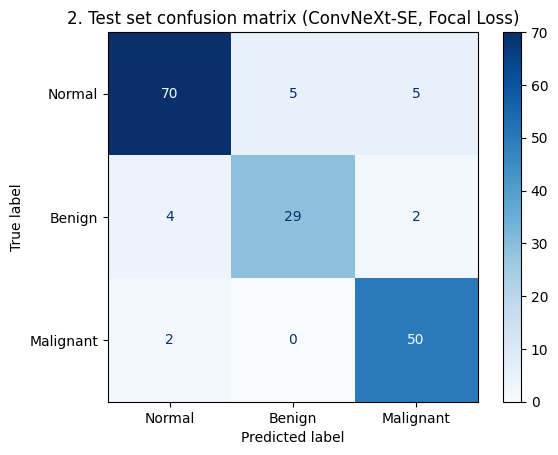

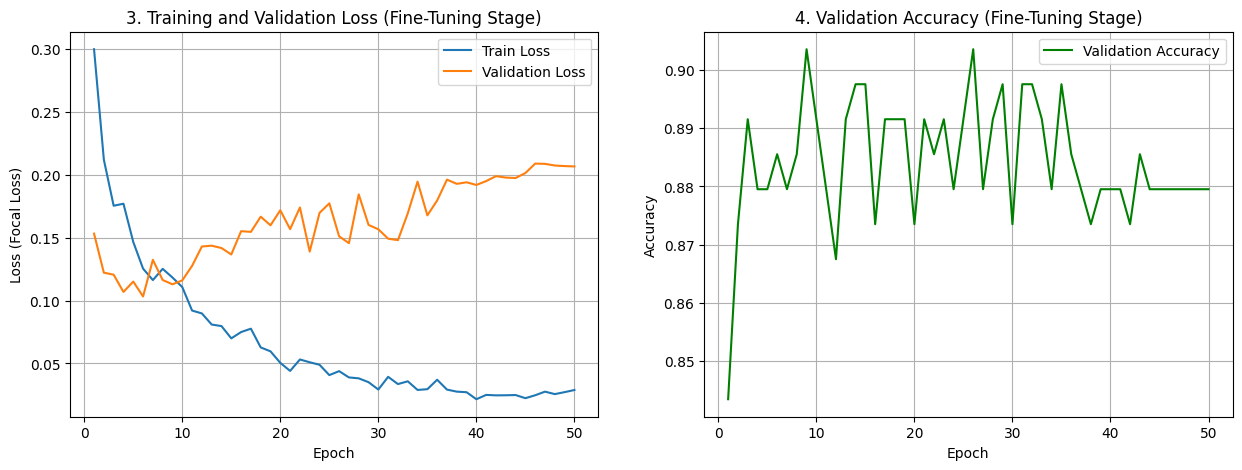

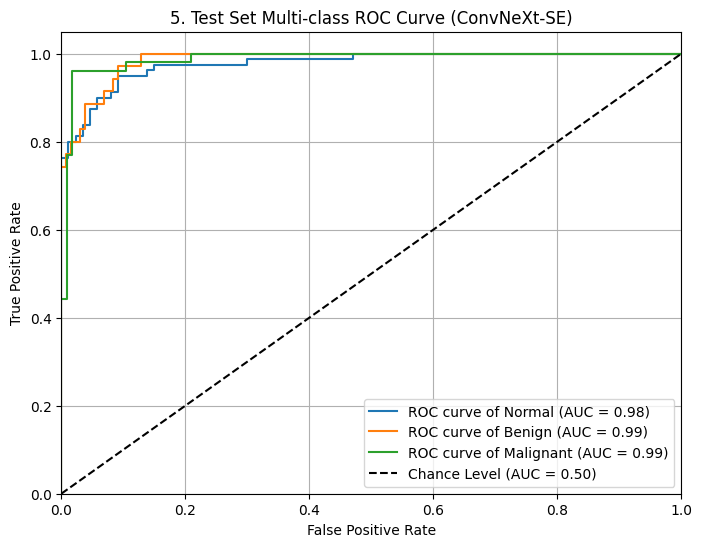

In [12]:
# --- Metrics and Plots ---
if final_labels is not None:
    print("\n## 1. Test Set Classification Report (ConvNeXt-SE + Focal Loss)")
    print("-----------------------------------------------------------------")
    print(classification_report(final_labels, final_preds, target_names=CLASS_NAMES, zero_division=0))

    # --- B. Test Set Confusion Matrix Plot ---
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(final_labels, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues) 
    plt.title('2. Test set confusion matrix (ConvNeXt-SE, Focal Loss)')
    plt.savefig('confusion_matrix_se_focal.png') 

    # --- C. Validation Loss and Accuracy Plots (During Training) ---
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    ax[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    ax[0].set_title('3. Training and Validation Loss (Fine-Tuning Stage)')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss (Focal Loss)')
    ax[0].legend(); ax[0].grid(True)
    ax[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    ax[1].set_title('4. Validation Accuracy (Fine-Tuning Stage)')
    ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Accuracy')
    ax[1].legend(); ax[1].grid(True)
    plt.savefig('loss_accuracy_se_focal.png') 

    # --- D. Test Set ROC Curve Plot (One vs. Rest) ---
    plt.figure(figsize=(8, 6))
    y_true_one_hot = np.eye(NUM_CLASSES)[final_labels]
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], final_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve of {CLASS_NAMES[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.50)')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('5. Test Set Multi-class ROC Curve (ConvNeXt-SE)')
    plt.legend(loc="lower right"); plt.grid(True)
    plt.savefig('roc_curve_se_focal.png')

    print("✅ All test set evaluation metrics and plots generated.")
else:
    print("⚠️ Cannot generate plots: Training did not run or failed to produce test results.")